In [128]:
#-----------------------------------------------------------------------
# Solution to the compressible Blasius equation (boundary value problem)
#
# 2 (ρ μ f'')' + f f'' = 0
# (ρ μ h')' + Pr f h' + Pr (γ-1) Ma^2 ρ μ (f'')^2 = 0
#
# where
#    f: Similarity form for the stream function = ψ/√(2 ν_∞ U x)
#    h: Specific enthalpy at the wall
#
# with isothermal bc:
#     f(0)  = f'(0) = 0 
#     f'(∞) = 1
#     h(∞)  = 1
#     h     = θ(0)
#
# following Howarth-Dorodnitsyn transformation 
#     θ     = T / T_∞
#-----------------------------------------------------------------------

In [129]:
using Plots
using Polynomials
using FastGaussQuadrature
using NLsolve
using Interpolations
using LinearAlgebra

In [130]:
default(linewidth=2)
γ      = 1.4;  # specific heat ratio
Pr     = 0.7;  # Prandtl number
Ma     = 1.0;  # Mach number
h_wall = 1;

In [131]:
η_max = 10.0
N = 30
x_resid = gausslegendre(N-3)[1]
dx_dη = 2 / η_max

UnpackCheb(X) = ChebyshevT(X[1:N]), ChebyshevT(X[N+1:end]);

In [132]:
X = zeros(2N-1);

In [133]:
function CompressibleBlasiusResidual(X)
    f, h = UnpackCheb(X)
    f_η = derivative(f, 1) * dx_dη
    f_ηη = derivative(f_η, 1) * dx_dη
    f_ηηη = derivative(f_ηη, 1) * dx_dη
    h_η = derivative(h, 1) * dx_dη
    h_ηη = derivative(h_η, 1) * dx_dη
    blasius = 2 * f_ηηη + f_ηη * f
    blasius_h = h_ηη + Pr * f * h_η + Pr * (γ - 1) * Ma * Ma * f_ηη * f_ηη # enthalpy equation
    R = zeros(2N-1)
    R[1] = f(-1)
    R[2] = f_η(-1)
    R[3] = f_η(1.) - 1
    R[4:N] = blasius.(x_resid)
    R[N+1] = h(-1.) - h_wall
    R[N+2] = h(1) - 1
    R[N+3:end] = blasius_h.(x_resid)
    R
end

CompressibleBlasiusResidual (generic function with 1 method)

In [134]:
solution = nlsolve(CompressibleBlasiusResidual, X)
f, h = UnpackCheb(solution.zero)
f_η  = derivative(f, 1) * dx_dη
f_ηη = derivative(f_η, 1) * dx_dη;

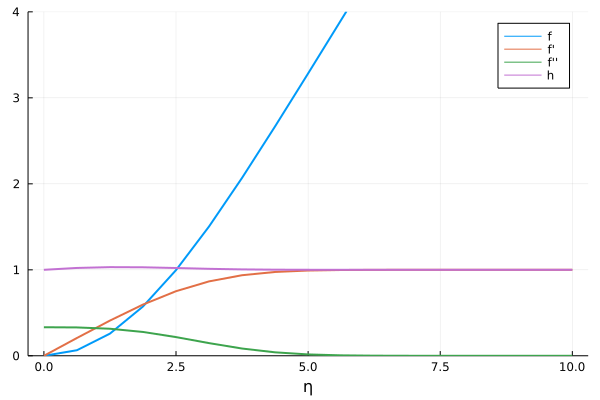

In [135]:
nelem = 16
x = LinRange(-1, 1, nelem+1)
x_to_η(x) = (x .+ 1) * η_max / 2
η = x_to_η(x)
plot(η, [f.(x) f_η.(x) f_ηη.(x) h.(x)], 
     label=["f" "f'" "f''" "h"], xlabel="η", ylim=(0, 4))

In [136]:
function TemperatureFromE(energy, velocity)
     f(x) = energy(x) - velocity(x)^2
     f
end

function TemperatureFromE_lin(x, η, u, T)
     u_lin = LinearInterpolation(η, u.(x))
     E_lin = LinearInterpolation(η, T.(x) + u.(x) .^ 2)
     TemperatureFromE(E_lin, u_lin)      
 end

TemperatureFromE_lin (generic function with 1 method)

In [137]:
u = f_η;
T = h;   # T = T_∞ * h

# primitive 
T_prim_interps = LinearInterpolation(η, T.(x));  

# conservative
T_cons_interps = TemperatureFromE_lin(x, η, u, T);

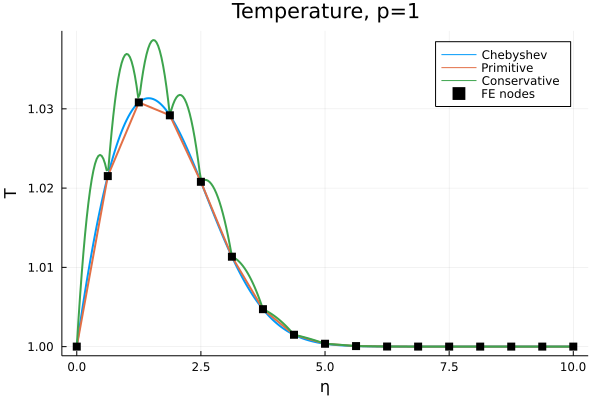

In [138]:
xx = LinRange(-1, 1, 300)
plot(x_to_η(xx), [T.(xx), T_prim_interps(x_to_η(xx)), T_cons_interps.(x_to_η(xx))], 
     label=["Chebyshev" "Primitive" "Conservative"], 
     title="Temperature, p=1", xlabel="η", ylabel="T")
scatter!(η, T.(x), label="FE nodes", color=:black, markershape=:square)

In [139]:
# energy
function EnergyFromT(temperature, velocity)
    f(x) = temperature(x) + velocity(x)^2
    f
end

function EnergyFromT_lin(x, η, u, T)
    u_lin = LinearInterpolation(η, u.(x))
    T_lin = LinearInterpolation(η, T.(x))
    EnergyFromT(T_lin, u_lin)      
end

E_cons_interps = LinearInterpolation(η, T.(x) + u.(x) .^ 2);
E_prim_interps = EnergyFromT_lin(x, η, u, T);

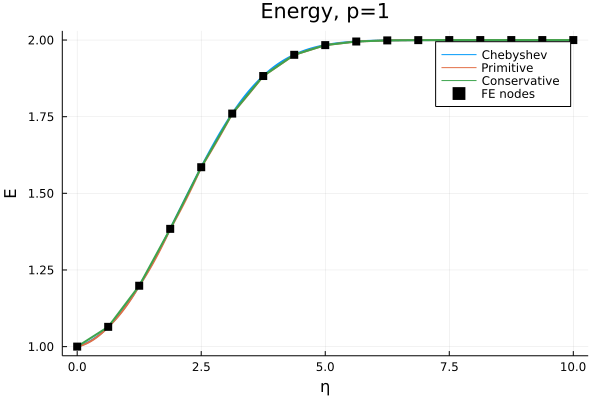

In [140]:
plot(x_to_η(xx), [T.(xx) + u.(xx) .^ 2, E_prim_interps.(x_to_η(xx)), E_cons_interps(x_to_η(xx))], 
     label=["Chebyshev" "Primitive" "Conservative"], 
     title="Energy, p=1", xlabel="η", ylabel="E")
scatter!(η, T.(x) + u.(x) .^ 2, label="FE nodes", color=:black, markershape=:square)

In [141]:
using SparseArrays
using FastGaussQuadrature

In [142]:
function mesh(P, nelem)
    x = LinRange(-1, 1, nelem+1)
    rows = Int[]
    cols = Int[]
    for i in 1:nelem
        append!(rows, (i-1)*P+1:i*P)
        append!(cols, (i-1)*(P-1)+1:i*(P-1)+1)
    end
    x, sparse(cols, rows, ones(nelem*P))'
end

mesh (generic function with 1 method)

In [143]:
function xnodal(x, P)
    nelem = length(x) - 1
    xn = Float64[]
    xref, _ = gausslobatto(P)
    for i in 1:nelem
        xL, xR = x[i:i+1]
        append!(xn, (xL+xR)/2 .+ (xR-xL)/2 * xref[1+(i>1):end])
    end
    xn
end

xnodal (generic function with 1 method)

In [144]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

vander_legendre_deriv (generic function with 2 methods)

In [145]:
function basis(P, q)
    xn, _ = gausslobatto(P)
    Pk, _ = vander_legendre_deriv(xn)
    Bp, _ = vander_legendre_deriv(q, P)
    B = Bp / Pk
    B
end

basis (generic function with 1 method)

In [146]:
struct Interp
    P::Int
    nelem::Int
    x::Vector
    xn::Vector
    Et::Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}
    B::Matrix
    function Interp(P, nelem)
        x, Et = mesh(P, nelem)
        xn = xnodal(x, P)
        B = basis(P, x)
        new(P, nelem, x, xn, Et,B)
    end
end

In [147]:
function element(intp, e)
    xL, xR = intp.x[e:e+1]
    E = intp.Et'[:, (e-1)*intp.P+1:e*intp.P]'
    dXdx = ones(intp.P) * 2 / (xR - xL)
    E, dXdx
end

element (generic function with 1 method)

In [148]:
P, nelem = 3, 8
x, E = mesh(P, nelem);
xn = xnodal(x, P);
intp = Interp(P, nelem);

In [149]:
function interpolate(intp, u)
    function f(x)
        # Find the element that contains point x
        right = max(2, searchsortedfirst(intp.x, x))
        left = right - 1
        E, _ = element(intp, left)
        x0 = .5*(intp.x[left] + intp.x[right])
        h = intp.x[right] - intp.x[left]
        X = (x - x0) * 2 / h    # point x in reference element
        BX = basis(intp.P, [X]) # basis evaluation to X
        (BX * E * u)[1]
    end
    f
end

T_fe = interpolate(intp, T.(intp.xn))
u_fe = interpolate(intp, u.(intp.xn))
E_fe = interpolate(intp, T.(intp.xn) + u.(intp.xn) .^ 2); # interpolate nodally exact energy

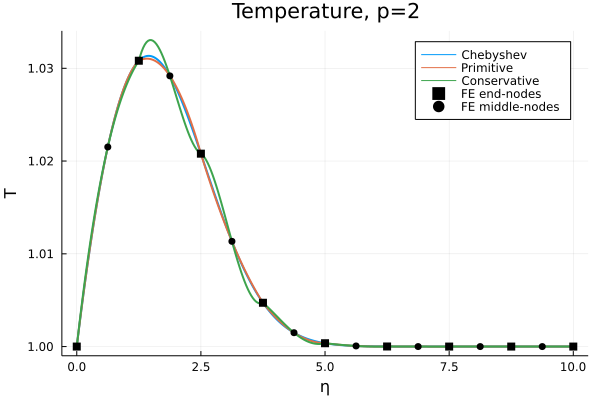

In [150]:
xx = LinRange(-1, 1, 300)
plot(x_to_η.(xx), [T.(xx) T_fe.(xx) E_fe.(xx)-u_fe.(xx).^2], 
     label=["Chebyshev" "Primitive" "Conservative"], 
     title="Temperature, p=2", xlabel="η", ylabel="T")
odd  = 1:2:size(intp.xn)[1]
even = 2:2:size(intp.xn)[1]
scatter!(x_to_η.(intp.xn)[odd], T.(intp.xn)[odd], 
         label="FE end-nodes", color=:black, markershape=:square)
scatter!(x_to_η.(intp.xn)[even], T.(intp.xn)[even], 
         label="FE middle-nodes", color=:black)

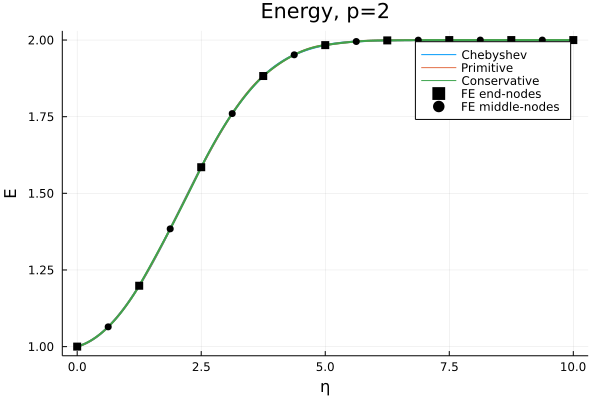

In [151]:
#energy
plot(x_to_η.(xx), [T.(xx) + u.(xx) .^2, T_fe.(xx) + u_fe.(xx).^2, E_fe.(xx)], 
      label=["Chebyshev" "Primitive" "Conservative"], 
      title="Energy, p=2", xlabel="η", ylabel="E")
odd  = 1:2:size(intp.xn)[1]
even = 2:2:size(intp.xn)[1]
scatter!(x_to_η.(intp.xn)[odd], T.(intp.xn)[odd] + u.(intp.xn)[odd].^2, 
         label="FE end-nodes", color=:black, markershape=:square)
scatter!(x_to_η.(intp.xn)[even], T.(intp.xn)[even] + u.(intp.xn)[even].^2, 
         label="FE middle-nodes", color=:black)